# Logistic Regression实践


In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.utils.data as data
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [2]:
NUM_INPUT = 2     # 样本特征维度
NUM_SAMPLE = 1000 # 生成的样本数量
BATCH_SIZE = 10   # 批大小
EPOCH = 100       # 训练迭代轮数

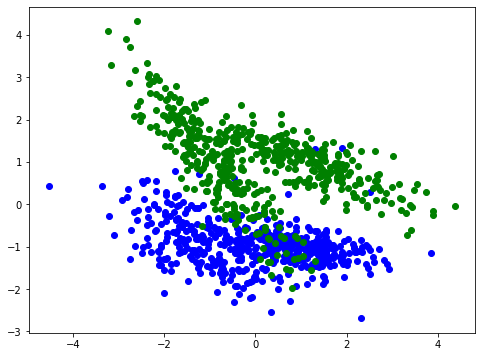

In [3]:
"""
使用sklearn.datasets中的make_classification函数生成1000个二分类数据
选择random_state=7是因为它的图片看起来比较像线性可分的。
"""
x, y = make_classification(n_samples=NUM_SAMPLE, n_features=NUM_INPUT, 
                           n_redundant=0,random_state=7)
# rng = np.random.RandomState(8)
# x += rng.uniform(size=x.shape)
unique_labels = set(y)
colors = ['b', 'g']
plt.figure(figsize=(8,6))
for k, color in zip(unique_labels, colors):
    x_k = x[y==k]
    plt.scatter(x_k[:, 0], x_k[:, 1], c=color)
plt.show()

In [4]:
x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y)
train_dataset = data.TensorDataset(x[:800], y[:800])
train_data_iter = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = data.TensorDataset(x[800:], y[800:])
test_data_iter = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(2, 1)
        nn.init.normal_(self.linear.weight, mean=0, std=1)
        
    def forward(self, x):
        prob = torch.sigmoid(self.linear(x)).view(-1, 1)
        # return torch.cat((prob, 1 - prob), 1)
        return torch.cat((1 - prob, prob), 1)
    
    def predict(self, x):
        prob_result = torch.squeeze(torch.sigmoid(self.linear(x)))
        return (prob_result > 0.5).int()

In [6]:
model = LogisticRegression()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.04)
print(model)
print(optimizer)

LogisticRegression(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.04
    weight_decay: 0
)


In [7]:
for epoch in range(EPOCH):
    for x, y in train_data_iter:
        output = model(x)
        l = loss(output, y) + 0.1 * (model.linear.weight ** 2).sum() # 使用了L2正则
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print("epoch: {}, loss: {}".format(epoch, l.item()))

epoch: 0, loss: 0.5829622745513916
epoch: 10, loss: 0.6055007576942444
epoch: 20, loss: 0.6221171617507935
epoch: 30, loss: 0.5479621887207031
epoch: 40, loss: 0.6375892758369446
epoch: 50, loss: 0.5936776995658875
epoch: 60, loss: 0.6206681728363037
epoch: 70, loss: 0.6266763806343079
epoch: 80, loss: 0.6178872585296631
epoch: 90, loss: 0.5892415046691895


In [8]:
# 使用测试集对模型进行测试，仅仅考虑了准确率单一指标
count = torch.tensor(0)
for x, y in test_data_iter:
    # print("true label: {}".format(y))
    output = model.predict(x)
    # print("pred label: {}\n".format(output))
    count += (output == y).sum()  
print("The accuracy of the model is {}".format(count.item()/200))

The accuracy of the model is 0.94
